# Задание

Реализовать самостоятельно логистическую регрессию

1) Обучить ее методом градиентного спуска

Методом nesterov momentum

Методом rmsprop

2) В качестве dataset’а взять Iris, оставив 2 класса:

Iris Versicolor

Iris Virginica

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import seaborn as sbs
from sklearn.metrics import roc_curve,roc_auc_score

In [13]:
iris_ds = load_iris()
X = pd.DataFrame(iris_ds['data'],columns=iris_ds['feature_names'])
y = pd.Series(iris_ds['target'],name='iris_type')
X = X[y.isin([1, 2])] 
y = y[y.isin([1, 2])] 
y = np.floor(y/2)
y = y.astype(int)
full_iris = pd.concat([X,y],axis=1)
assert len(X)==len(y)

In [14]:
X.shape[0]

100

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,shuffle=True)

In [16]:
X_train = np.hstack([np.array(X_train),np.ones([len(X_train),1])])
X_test = np.hstack([np.array(X_test),np.ones([len(X_test),1])])

In [17]:
full_iris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 5 columns):
sepal length (cm)    100 non-null float64
sepal width (cm)     100 non-null float64
petal length (cm)    100 non-null float64
petal width (cm)     100 non-null float64
iris_type            100 non-null int64
dtypes: float64(4), int64(1)
memory usage: 4.7 KB


Визуализация классов:

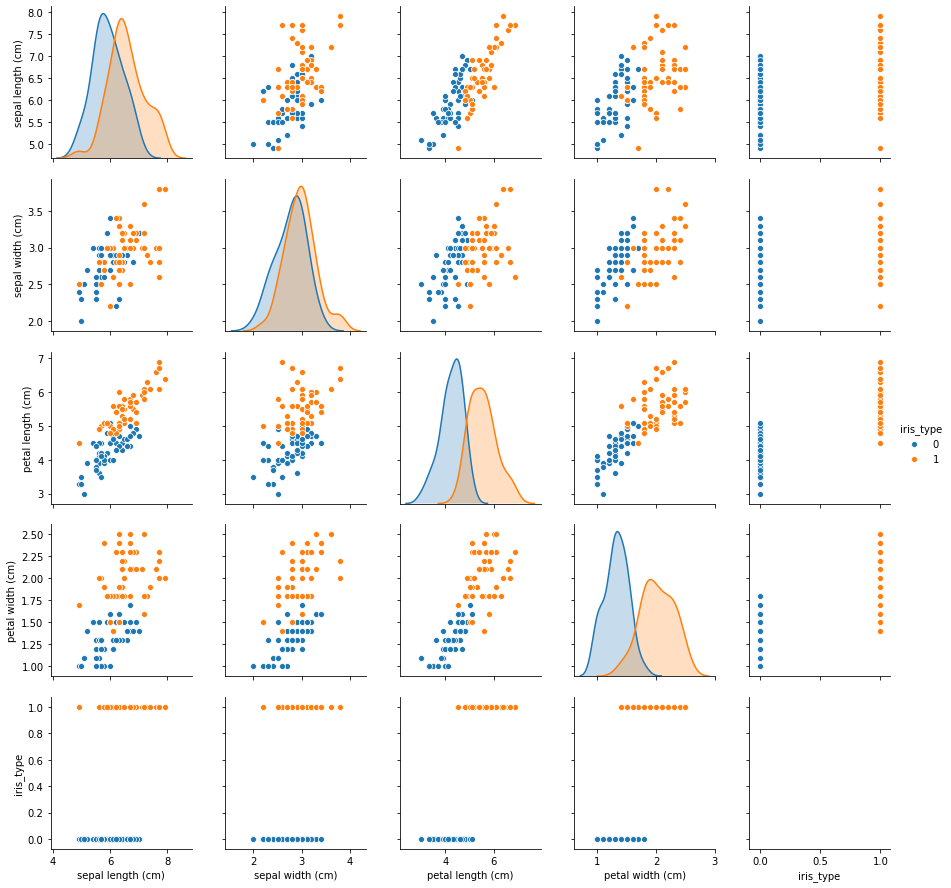

In [20]:
sbs.pairplot(hue='iris_type',data=full_iris)

# Логистическая регрессия

In [21]:
def sigmoid(func):
    return 1/(1+np.exp(-func))
def log_reg_predict (X, params):
    if X.shape[1] != params.shape[0]:
        print ("Проверьте параметры!")
    else:        
        return sigmoid(np.dot(X,params))

In [22]:
test_params = np.array([0,0,0,0,0])
test_run_results = log_reg_predict(X_train,test_params)
assert test_run_results.reshape((-1,)).shape[0] == X_train.shape[0] 
assert np.sum(test_run_results==.5) == X_train.shape[0] 

In [23]:
def log_reg_grad(X,params,y):
    return np.dot(sigmoid(np.dot(X,params) - y),X)/y.shape[0]

In [24]:
log_reg_grad(X_train,test_params,y_train)

array([2.34438203, 1.09594068, 1.80092925, 0.60723703, 0.37869425])

In [25]:
def log_reg_cost(X,params,y):
    pred = log_reg_predict(X,params)
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

In [26]:
log_reg_cost(X_train,test_params,y_train)

0.6931471805599453

In [45]:
performance = {}

# Градиентный спуск

Достигнут минимум функции при LR=0.001 = 0.6478144510497057 и 144 эпохах
Достигнут минимум функции при LR=0.0001 = 0.6477917166306157 и 1440 эпохах
Достигнут минимум функции при LR=1e-05 = 3.6104528383861236 и 2000 эпохах
Достигнут минимум функции при LR=1e-06 = 4.209344827099981 и 2000 эпохах
Достигнут минимум функции при LR=1e-07 = 4.269256385474316 и 2000 эпохах


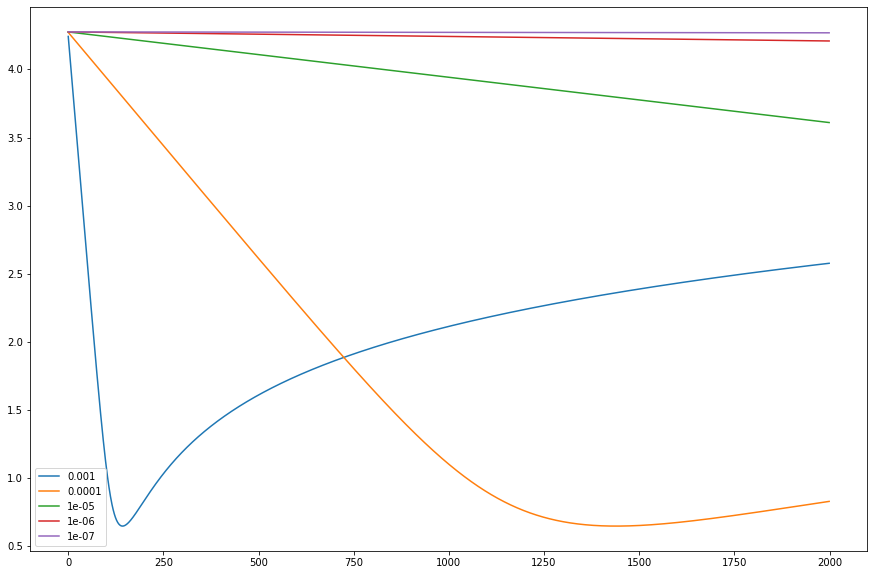

In [30]:
np.random.seed(42)
EPOCHS = 2000

init_params = np.random.uniform(size=X_train.shape[1])
minimum_costs = {}

global_gradients = []
global_params = []
global_costs = []

plt.figure(figsize=(15,10))
for LR in [.001,.0001,.00001,.000001,.0000001]:
    params = np.copy(init_params)
    
    costs = []
    grads_draw = []
    params_draw = [np.copy(params),]
    for _ in range(EPOCHS):
        gradients = log_reg_grad(X_train,params,y_train)
        grads_draw.append(gradients)
        params -= LR*gradients        
        params_draw.append(np.copy(params))
        costs.append(log_reg_cost(X_train,params,y_train))
        
    print(f"Достигнут минимум функции при LR={LR} = {np.min(costs)} и {np.argmin(costs)+1} эпохах")  
    minimum_costs[LR] = np.min(costs)
    plt.plot(range(len(costs)),costs,label=LR)
    
    global_gradients.append(grads_draw)
    global_params.append(params_draw)
    global_costs.append(costs)
    
plt.legend()
plt.show()

Выбираем тактику тренировать дольше с малым значением LR:

Достигнут минимум функции при LR=1e-05 = 0.6477911619706395 и 14406 эпохах


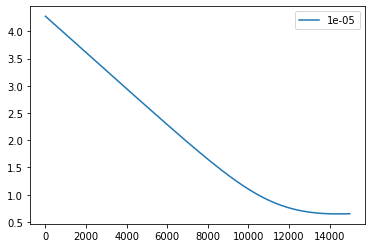

In [33]:
EPOCHS = 15000
LR = 1e-05

params = np.copy(init_params)
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,params,y_train)
    params -= LR*gradients
    costs.append(log_reg_cost(X_train,params,y_train))

print(f"Достигнут минимум функции при LR={LR} = {np.min(costs)} и {np.argmin(costs)+1} эпохах")    
plt.plot(range(len(costs)),costs,label=LR)

plt.legend()
plt.show()

Проверим стратегию ранней остановки:

Ранняя остановка при 1441 эпохах
Достигнут минимум функции при LR=0.0001 = 0.6477917166306157 и 1440 эпохах


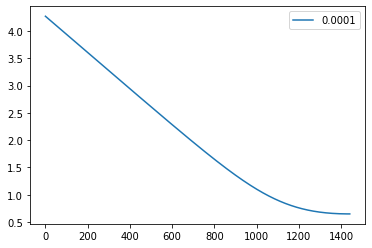

In [49]:
EPOCHS = 10000
LR = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]

gd_params = np.copy(init_params)
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,gd_params,y_train)
    gd_params -= LR*gradients
    costs.append(log_reg_cost(X_train,gd_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"Ранняя остановка при {_} эпохах")
            break

performance['GD'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Достигнут минимум функции при LR={LR} = {np.min(costs)} и {performance['GD']['EPOCHS']} эпохах")
plt.plot(range(len(costs)),costs,label=LR)

plt.legend()
plt.show()

In [50]:
gd_pred_proba = log_reg_predict(X_test,gd_params)
performance['GD']['ACCURACY'] = np.sum((gd_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['GD']['ROCAUC'] = roc_auc_score(y_test,gd_pred_proba)
print (f"Accuracy = {performance['GD']['ACCURACY']:.2f}, ROC_AUC={performance['GD']['ROCAUC']:.3f}")

Accuracy = 0.75, ROC_AUC=0.844


# Метод nesterov momentum

Достигнут минимум функции при LR=0.0001 и GAMMA=0.5 = 0.6477945051962113 и 720 эпохах
Достигнут минимум функции при LR=1e-05 и GAMMA=0.5 = 2.947020087388687 и 2000 эпохах
Достигнут минимум функции при LR=1e-06 и GAMMA=0.5 = 4.142846114704054 и 2000 эпохах
Достигнут минимум функции при LR=1e-07 и GAMMA=0.5 = 4.262606081737907 и 2000 эпохах
Достигнут минимум функции при LR=0.0001 и GAMMA=0.9 = 0.6478864636532856 и 147 эпохах
Достигнут минимум функции при LR=1e-05 и GAMMA=0.9 = 0.6478011631248678 и 1442 эпохах
Достигнут минимум функции при LR=1e-06 и GAMMA=0.9 = 3.613444773815832 и 2000 эпохах
Достигнут минимум функции при LR=1e-07 и GAMMA=0.9 = 4.209644374015994 и 2000 эпохах
Достигнут минимум функции при LR=0.0001 и GAMMA=0.975 = 0.6486363217068258 и 63 эпохах
Достигнут минимум функции при LR=1e-05 и GAMMA=0.975 = 0.6479297336442091 и 376 эпохах
Достигнут минимум функции при LR=1e-06 и GAMMA=0.975 = 1.6994075054315723 и 2000 эпохах
Достигнут минимум функции при LR=1e-07 и GAMMA=0.975 = 

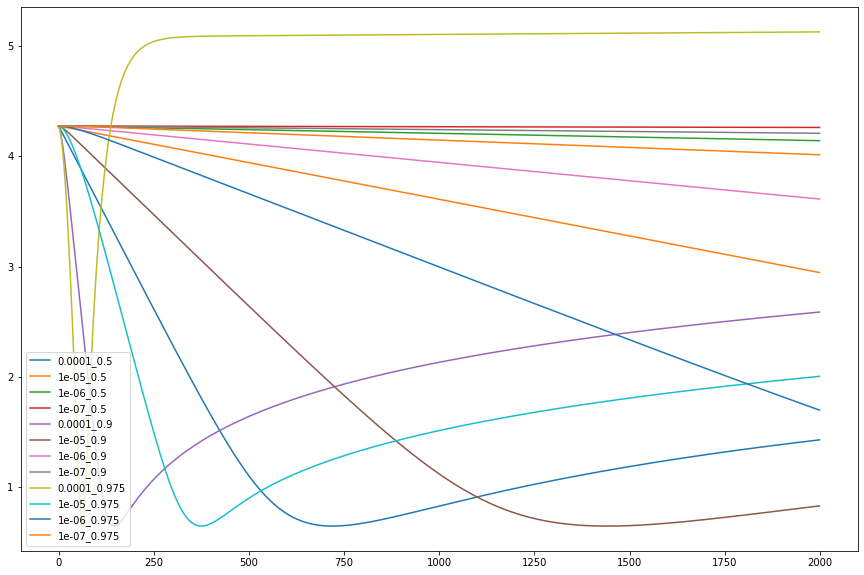

In [51]:
EPOCHS = 2000

minimum_costs = {}

plt.figure(figsize=(15,10))
for GAMMA in [.5,.9,.975]:
    for LR in [.0001,.00001,.000001,.0000001]:
        params = np.copy(init_params)

        momentum = np.zeros(params.shape[0])

        costs = []

        for _ in range(EPOCHS):
            gradients = log_reg_grad(X_train,params-GAMMA*momentum,y_train)
            momentum = GAMMA*momentum + LR*gradients
            params -= momentum
            costs.append(log_reg_cost(X_train,params,y_train))

        print(f"Достигнут минимум функции при LR={LR} и GAMMA={GAMMA} = {np.min(costs)} и {np.argmin(costs)+1} эпохах")  
        plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")
        minimum_costs[(LR,GAMMA)] = np.min(costs)
plt.legend()
plt.show()

Ранняя остановка на 721 эпохах
Достигнут минимум функции при LR=0.0001 и GAMMA=0.5 = 0.6477945051962113 и 720 эпохах


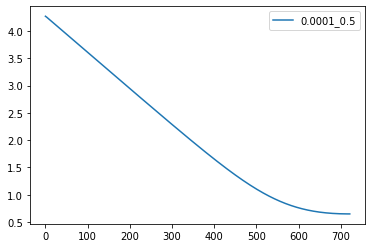

In [53]:
EPOCHS = 10000
min_key = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]
LR = min_key[0]
GAMMA = min_key[1]

nes_params = np.copy(init_params)
momentum = np.zeros(params.shape[0])
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,nes_params-GAMMA*momentum,y_train)
    momentum = GAMMA*momentum + LR*gradients
    nes_params -= momentum
    costs.append(log_reg_cost(X_train,nes_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"Ранняя остановка на {_} эпохах")
            break

performance['NESTEROV'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Достигнут минимум функции при LR={LR} и GAMMA={GAMMA} = {np.min(costs)} и {performance['NESTEROV']['EPOCHS']} эпохах")  
plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
plt.show()

In [54]:
nes_pred_proba = log_reg_predict(X_test,nes_params)
performance['NESTEROV']['ACCURACY'] = np.sum((nes_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['NESTEROV']['ROCAUC'] = roc_auc_score(y_test,nes_pred_proba)
print (f"Accuracy = {performance['NESTEROV']['ACCURACY']:.2f}, ROC_AUC={performance['NESTEROV']['ROCAUC']:.3f}")

Accuracy = 0.75, ROC_AUC=0.844


# Метод RMSProp

Достигнут минимум функции при 0.1 и GAMMA=0.1 = 0.6869255167893898 и 6 эпохах
Достигнут минимум функции при 0.01 и GAMMA=0.1 = 0.659503533111273 и 57 эпохах
Достигнут минимум функции при 0.001 и GAMMA=0.1 = 0.6590263149905466 и 574 эпохах
Достигнут минимум функции при 0.0001 и GAMMA=0.1 = 2.8162531893817624 и 2000 эпохах
Достигнут минимум функции при 1e-05 и GAMMA=0.1 = 4.129792809452638 и 2000 эпохах
Достигнут минимум функции при 0.1 и GAMMA=0.5 = 0.6676541131189856 и 5 эпохах
Достигнут минимум функции при 0.01 и GAMMA=0.5 = 0.6593789350874042 и 57 эпохах
Достигнут минимум функции при 0.001 и GAMMA=0.5 = 0.6590173281396591 и 574 эпохах
Достигнут минимум функции при 0.0001 и GAMMA=0.5 = 2.8157870642062255 и 2000 эпохах
Достигнут минимум функции при 1e-05 и GAMMA=0.5 = 4.129745850801857 и 2000 эпохах
Достигнут минимум функции при 0.1 и GAMMA=0.9 = 0.689238807810994 и 2 эпохах
Достигнут минимум функции при 0.01 и GAMMA=0.9 = 0.6587548412663335 и 52 эпохах
Достигнут минимум функции при 0.

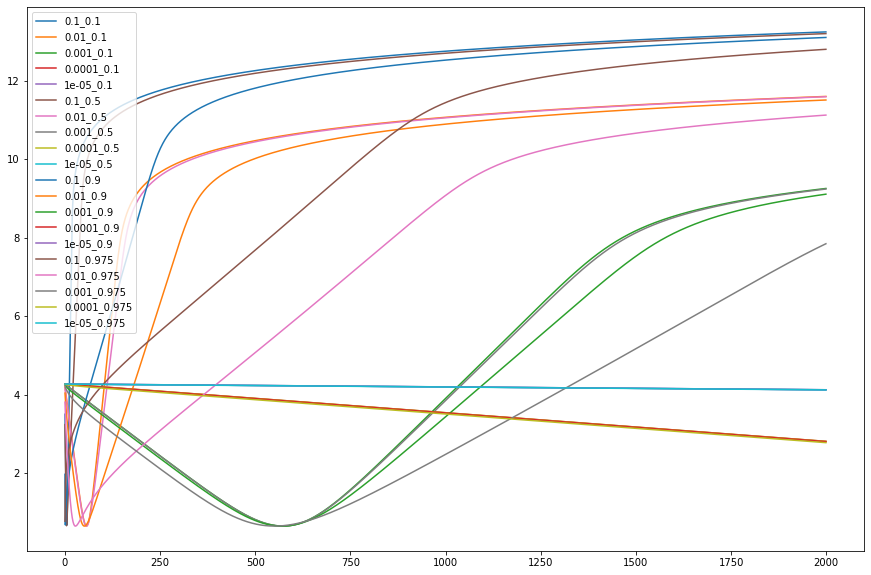

In [55]:
EPOCHS = 2000

minimum_costs = {}

plt.figure(figsize=(15,10))
for GAMMA in [.1,.5,.9,.975]:
    for LR in [.1,.01,.001,.0001,.00001]:
        params = np.copy(init_params)

        e = np.zeros(params.shape[0])

        costs = []

        for _ in range(EPOCHS):
            gradients = log_reg_grad(X_train,params-GAMMA*momentum,y_train)
            e = GAMMA*e + (1-GAMMA)*np.square(gradients)            
            params -= LR*gradients/np.sqrt(e+1e-10)
            costs.append(log_reg_cost(X_train,params,y_train))

        print(f"Достигнут минимум функции при {LR} и GAMMA={GAMMA} = {np.min(costs)} и {np.argmin(costs)+1} эпохах")  
        minimum_costs[(LR,GAMMA)] = np.min(costs)
        plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
plt.show()

Ранняя остановка при 53 эпохах
Достигнут минимму функции при LR=0.01 и GAMMA=0.9 = 0.6587548412663335 при 52 эпохах
Final cost = 0.66454


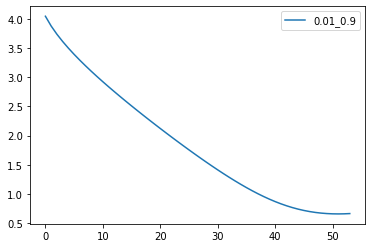

In [56]:
EPOCHS = 10000
min_key = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]
LR = min_key[0]
GAMMA = min_key[1]

rms_params = np.copy(init_params)
e = np.zeros(rms_params.shape[0])
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,rms_params-GAMMA*momentum,y_train)
    e = GAMMA*e + (1-GAMMA)*np.square(gradients)            
    rms_params -= LR*gradients/np.sqrt(e+1e-10)
    costs.append(log_reg_cost(X_train,rms_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"Ранняя остановка при {_} эпохах")
            break

performance['RMSPROP'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Достигнут минимму функции при LR={LR} и GAMMA={GAMMA} = {np.min(costs)} при {performance['RMSPROP']['EPOCHS']} эпохах")  
print(f"Final cost = {costs[-1]:.5f}")
plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
plt.show()

In [57]:
rms_pred_proba = log_reg_predict(X_test,rms_params)
performance['RMSPROP']['ACCURACY'] = np.sum((rms_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['RMSPROP']['ROCAUC'] = roc_auc_score(y_test,rms_pred_proba)
print (f"Accuracy = {performance['RMSPROP']['ACCURACY']:.2f}, ROC_AUC={performance['RMSPROP']['ROCAUC']:.3f}")

Accuracy = 0.75, ROC_AUC=0.885


# Вывод

In [58]:
performance

{'GD': {'EPOCHS': 1440, 'ACCURACY': 0.75, 'ROCAUC': 0.84375},
 'NESTEROV': {'EPOCHS': 720, 'ACCURACY': 0.75, 'ROCAUC': 0.84375},
 'RMSPROP': {'EPOCHS': 52, 'ACCURACY': 0.75, 'ROCAUC': 0.8854166666666667}}

Рассмотренные методы работают с одинаковой точностью, но скорость получения результата растет от градиентного спуска к RMS Prop